# jn para el analisis de datos csv

Descripción: Este script sirve para el analisis de datos obtenidos de un VNA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import math
import cmath
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from matplotlib.widgets import Slider, Button
from lmfit import minimize, Parameters, fit_report

## Lectura de la data

In [5]:
import pandas as pd

In [6]:
file='F2P125d.csv'
names=['Freq(GHz)', 'Amp(dB)']
names2=['Freq(GHz)','Phase(rad)']

df=pd.read_csv(file, names=names, skiprows=18, nrows=200)
df2=pd.read_csv(file, names=names2, skiprows=225, nrows=200)
Freq=df['Freq(GHz)']*1e-9
Amp=df['Amp(dB)']+66
Pha=df2['Phase(rad)']

In [4]:
Freq

0      8.115059
1      8.115064
2      8.115069
3      8.115074
4      8.115079
         ...   
195    8.116034
196    8.116039
197    8.116044
198    8.116049
199    8.116054
Name: Freq(GHz), Length: 200, dtype: float64

## Plots 

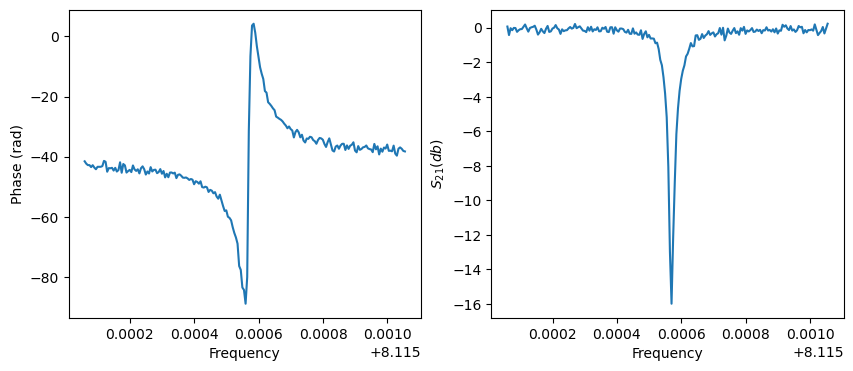

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(Freq,Pha)
ax[1].plot(Freq,Amp)
ax[0].set_xlabel('Frequency')
ax[1].set_xlabel('Frequency')
ax[0].set_ylabel('Phase (rad)')
ax[1].set_ylabel(r'$S_{21}(db)$')

plt.show()

# Fitting

### Funciones Fit

In [8]:
def fit_function(params, f=None, dat1=None, dat2=None):
    
    fr = params['fr']
    Qc = params['Qc']
    Qi = params['Qi']
    phi0 = params['phi0']
    A = amplitude(f, fr, Qc, Qi)
    P = phase(f, fr, Qc, Qi, phi0)

    resid1 = dat1 - A
    resid2 = dat2 - P
    return np.concatenate((resid1, resid2))
def amplitude(f,fc,Q_c,Q_i):
    """ Compute the Amplitude from the parameter !!! compute the amplitude in magnitude !!!! """
    
    x=f/fc-fc/f  #
    a=Q_c/Q_i    #loss coef 
    S21=(2*Q_c*x/((1+a)**2+4*Q_c**2*x**2))**2 + (1-(1+a)/((1+a)**2+4*Q_c**2*x**2))**2
    
   # Sd=10*np.log(S21)   
    Sd = S21
    return Sd
##### fase

def phase(f,fc,Q_c,Q_i,phi0):
    
    x=f/fc-fc/f
    a=Q_c/Q_i
    arg=(2*Q_c*x)/(a*(a+1)+4*Q_c**2*x**2)
    theta=np.arctan(arg)
    
    return phi0+theta*180/np.pi
def tphase(f,fc,Q_c,Q_i):
    
    h=0.01
    tan=(phase(fc+h,fc,Q_c,Q_i)-phase(fc,fc,Q_c,Q_i))/h
    
    return phase(fc,fc,Q_c,Q_i)+tan*(f-fc)
def ttphase(fc,Q_c,Q_i):
    
    a=Q_c/Q_i
    tan=1/(a*(a+1))*(4*Q_c/fc)
    
    return tan
def tangente(f):
    
    recta=phase(f0,f0,Qc,Qi)+ttphase(f0,Qc,Qi)*(f-f0)
    
    return recta
def real(f,fc,Q_c,Q_i):
    
    x=(f/fc-fc/f)
    a=Q_c/Q_i
    arg=(a*(a+1)+4*Q_c**2*x**2)/((a+1)**2+4*Q_c**2*x**2)
 
    return arg
def imag(f,fc,Q_c,Q_i):
    
    x=(f/fc-fc/f)
    a=Q_c/Q_i
    arg2=2*Q_c*x/((a+1)**2+4*Q_c**2*x**2)
    
    return arg2


## Fitting plot

In [32]:
%matplotlib tk
# Define frequency array
# Define initial parameters
# frequency list  !attention : amplitude and phase muste have the same frequency list!

## Freqyency
f_ = Freq
## amplitud**2 
amp_ = np.exp(2*Amp/10)
#Phase
angle_ = Pha

## initial parameters

init_phi0= 95
init_Qc = 20e3
init_Qi =  1.5e6
init_fr = f_[np.argmin(amp_)] #Estimation of the resonante frequency 

deltaphi=10
deltafr=0.001
deltaQc=1000000
deltaQi=100000000



f=[]
amp=[]
angle=[]

for k in range(0, len(f_)): 
    if init_fr-0.005<f_[k] and f_[k]<init_fr+0.005 : 
        f.append(f_[k])
        amp.append(amp_[k])
        angle.append(angle_[k])
f=np.array(f)
amp=np.array(amp)
angle=np.array(angle)
    


# Create the figure and the line that we will manipulate
######## ===========================================
fig, ax= plt.subplots(2, 1, figsize=(9, 8))
ax=ax.ravel()
amplitud_, =ax[0].plot(f, amp, label='Datos')
fase_,=ax[1].plot(f, angle,label='Datos')
line1,= ax[0].plot(f, amplitude(f,init_fr,init_Qc,init_Qi), lw=2, label='Ajuste')
line2,= ax[1].plot(f, phase(f,init_fr,init_Qc,init_Qi,init_phi0), lw=2,label='Ajuste')

ax[0].set_xlim([f[0],f[-1]])
ax[1].set_xlabel('Frecuencia [GHz]', fontsize=14)
ax[0].set_xlabel('Frecuencia [GHz]', fontsize=14)
ax[1].set_ylabel('Fase[rad]', fontsize=14)
ax[0].set_ylabel(r'$|S_{21}|$', fontsize=14)
ax[1].set_ylim(-150,80)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

######## ===========================================
sliders=[]

# Make a horizontal slider to control fr.
axfr = plt.axes([0.25, 0.1, 0.65, 0.03])
fr_slider = Slider(
    ax=axfr,
    label=r'$f_0$ [GHz]',
    valmin=init_fr-deltafr,
    valmax=init_fr+deltafr,
    valinit=init_fr,
)
sliders.append(fr_slider)

# Make a vertically oriented slider to control phi
axphi = plt.axes([0.1, 0.25, 0.0225, 0.63])
phi_slider = Slider(
    ax=axphi,
    label=r"$\theta_0$ [deg]",
    color='green',
    valmin=init_phi0-deltaphi,
    valmax=init_phi0+deltaphi,
    valinit=init_phi0,
    orientation="vertical"
)
sliders.append(phi_slider)
# Make a horizontal slider to control qc.
axQc = plt.axes([0.25, 0.05, 0.65, 0.03])
Qc_slider = Slider(
    ax=axQc,
    label=r'$Q_c$',
    color='orange',
    valmin=init_Qc-deltaQc,
    valmax=init_Qc+deltaQc,
    valinit=init_Qc,
)
sliders.append(Qc_slider)

# Make a vertically oriented slider to control Qi
axQi = plt.axes([0.3, 0.05, 0.65, 0.03])
Qi_slider = Slider(
    ax=axQi,
    label=r"$Q_i$",
    valmin=init_Qi-deltaQi,
    valmax=init_Qi+deltaQi,
    valinit=init_Qi,
    orientation="vertical"
    #text_Qi = axQi.text(0.5, 1.02, f"Qi = {init_Qi}", transform=axQi.transAxes, ha='center', color='red')

)

sliders.append(Qi_slider)
## sliders savefig

# Make a vertically oriented slider to control Qi
axfig = plt.axes([0.5, 0.02, 0.65, 0.03])
fig_sliderb = Slider(
    ax=axfig,
    label=r"fig",
    valmin=1,
    valmax=10,
    valinit=0.1
)

sliders.append(fig_sliderb)

axfig = plt.axes([0.05, 8, 0.0225, 0.63])
fig_sliderb = Slider(
    ax=axfig,
    label=r"fig",
    valmin=1,
    valmax=10,
    valinit=0.1
)
sliders.append(fig_sliderb)



#### ======================================================
# The function to be called anytime a slider's value changes
def update(val):
    line1.set_ydata(amplitude(f, sliders[0].val,sliders[2].val,sliders[3].val))
    line2.set_ydata(phase(f,sliders[0].val,sliders[2].val,sliders[3].val,sliders[1].val))
    fig.canvas.draw_idle()


# register the update function with each slider
fr_slider.on_changed(update)
phi_slider.on_changed(update)
Qc_slider.on_changed(update)
Qi_slider.on_changed(update)

# Create buttons
resetax = plt.axes([0.05, 0.075, 0.1, 0.04])
parametsax = plt.axes([0.05, 0.025, 0.1, 0.04])
fitax = plt.axes([0.05, 0.125, 0.1, 0.04])
startaigan = plt.axes([0.05, 0.175, 0.1, 0.04])
forwardax = plt.axes([0.9, 0.95, 0.04, 0.04])
backwardax = plt.axes([0.1, 0.95, 0.04, 0.04])
savefigx = plt.axes([0.2, 0.95, 0.04, 0.04])


button = Button(resetax, 'Reset', color='red', hovercolor='yellow')
button2 = Button(parametsax,'GetParams', color='orange', hovercolor='yellow')
button3 = Button(fitax, 'Fit', color='blue', hovercolor='yellow')
button4 = Button(startaigan, 'StartAgain', color='green', hovercolor='yellow')
button5 = Button(forwardax, '>', hovercolor='orange')
button6 = Button(backwardax, '<', hovercolor='orange')
button7 = Button(savefigx, 'Save', hovercolor='orange')

def reset(event):
    sliders[0].reset()
    sliders[1].reset()
    sliders[2].reset()
    sliders[3].reset()

#Save the parameters in a file.txt
def getpars(event):
    global i 
    #filename="datos"+str(C[0][i])+".txt"
    filename="datos_fit"+".txt"
    #filename="datos".txt
    
    with open(filename,'w') as o:
        print('Resultados del Fitting', file=o)
        print(r'f0[GHz]',sliders[0].val,file=o)
        print(r'phi',sliders[1].val,file=o)
        print('Qc',sliders[2].val,file=o)
        print('Qi',sliders[3].val,file=o)
    
def fit(event):
    global f
    global amp
    global angle
    params = Parameters()
    params.add('fr', value=sliders[0].val)
    params.add('Qc', value=sliders[2].val)
    params.add('Qi', value=sliders[3].val)
    params.add('phi0', value=sliders[1].val)
    out = minimize(fit_function, params, kws={"f": f, "dat1":amp, "dat2": angle})
    a_=out.params['fr'].value
    b_ = out.params['Qc'].value
    c_= out.params['Qi'].value
    d_= out.params['phi0'].value
    line1.set_ydata(amplitude(f, a_,b_,c_))
    line2.set_ydata(phase(f,a_,b_,c_,d_))
    axfr.cla() #Clear the axis
    sliders[0].__init__(axfr, r'fr[Hz]',valmin=a_-deltafr, valmax=a_+deltafr, valinit=a_,)
    axphi.cla()
    sliders[1].__init__(ax=axphi,label=r"$\theta_0$ [rad]",valmin=d_-deltaphi,valmax=d_+deltaphi,valinit=d_,orientation="vertical")
    axQc.cla()
    sliders[2].__init__(ax=axQc,label=r'$Q_c$',valmin=b_-deltaQc,valmax=b_+deltaQc,valinit=b_)
    axQi.cla()
    sliders[3].__init__(ax=axQi,label=r'$Q_i$',valmin=c_-deltaQi,valmax=c_+deltaQi,valinit=c_,orientation="vertical")
    sliders[0].on_changed(update)
    sliders[1].on_changed(update)
    sliders[2].on_changed(update)
    sliders[3].on_changed(update)
    fig.canvas.draw_idle()

def start(event):
    global f
    global init_fr
    global init_Qc
    global init_Qi
    global init_phi0
    
    a_=init_fr
    b_ =init_Qc
    c_=init_Qi
    d_=init_phi0
    
    line1.set_ydata(amplitude(f, a_,b_,c_))
    line2.set_ydata(phase(f,a_,b_,c_,d_))
    
    axfr.cla() #Clear the axis
    sliders[0].__init__(axfr, 'f0[GHz]',valmin=a_-deltafr, valmax=a_+deltafr, valinit=a_,)
    axphi.cla()
    sliders[1].__init__(ax=axphi,label="Phi0 [rad]",valmin=d_-deltaphi,valmax=d_+deltaphi,valinit=d_,orientation="vertical")
    axQc.cla()
    sliders[2].__init__(ax=axQc,label='Qc',valmin=b_-deltaQc,valmax=b_+deltaQc,valinit=b_)
    axQi.cla()
    sliders[3].__init__(ax=axQi,label='Qi',valmin=c_-deltaQi,valmax=c_+deltaQi,valinit=c_,orientation="vertical")
    sliders[0].on_changed(update)
    sliders[1].on_changed(update)
    sliders[2].on_changed(update)
    sliders[3].on_changed(update)

    fig.canvas.draw_idle()
    
def forward(event):
    global i
    global f
    global amp
    global angle
    global init_fr
    global init_Qc
    global init_Qi
    global init_phi0
    
    i+=2

    
    
    f_ = A[i]
    amp_ = np.exp(2*B[i]/10)
    angle_ = B[i+1]
    
    deltaphi=10
    deltafr=0.001
    deltaQc=1000000
    deltaQi=100000000
    

    
    a_=f_[np.argmin(np.exp(2*B[i]/10))]
    b_=20e3
    c_=1.5e6
    d_=-100
    init_fr = a_
    init_Qc=b_
    init_Qi=c_
    init_phi0=d_
    

    f=[]
    amp=[]
    angle=[]

    for k in range(0, len(f_)): 
        if init_fr-0.005<f_[k] and f_[k]<init_fr+0.005 : 
            f.append(f_[k])
            amp.append(amp_[k])
            angle.append(angle_[k])
    f=np.array(f)
    amp=np.array(amp)
    angle=np.array(angle)
    
    ax[0].set_xlim([f[0],f[-1]])
    amplitud_.set_xdata(f)
    amplitud_.set_ydata(amp)
    fase_.set_xdata(f)
    fase_.set_ydata(angle)
    line1.set_xdata(f)
    line2.set_xdata(f)
    line1.set_ydata(amplitude(f, a_,b_,c_))
    line2.set_ydata(phase(f,a_,b_,c_,d_))
    
    axfr.cla() #Clear the axis
    sliders[0].__init__(axfr, 'fr[GHz]',valmin=a_-deltafr, valmax=a_+deltafr, valinit=a_,)
    axphi.cla()
    sliders[1].__init__(axphi,label="Phi0 [rad]",valmin=d_-deltaphi,valmax=d_+deltaphi,valinit=d_,orientation="vertical")
    axQc.cla()
    sliders[2].__init__(axQc,label='Qc',valmin=b_-deltaQc,valmax=b_+deltaQc,valinit=b_)
    axQi.cla()
    sliders[3].__init__(axQi,label='Qi',valmin=c_-deltaQi,valmax=c_+deltaQi,valinit=c_,orientation="vertical")
    sliders[0].on_changed(update)
    sliders[1].on_changed(update)
    sliders[2].on_changed(update)
    sliders[3].on_changed(update)

    fig.canvas.draw_idle()
    
    
    
def backward(event): 
    global i
    global f
    global amp
    global angle
    global init_fr
    global init_Qc
    global init_Qi
    global init_phi0
    
    i-=2
    
    f_ = A[i]

    amp_ = np.exp(2*B[i]/10)
    angle_ = B[i+1]
    deltaphi=10
    deltafr=0.001
    deltaQc=1000000
    deltaQi=100000000
    
    a_=f_[np.argmin(np.exp(2*B[i]/10))]
    b_=20e3
    c_=1.5e6
    d_=-100
    init_fr = a_   
    init_Qc=b_
    init_Qi=c_
    init_phi0=d_
    
    f=[]
    amp=[]
    angle=[]

    for k in range(0, len(f_)): 
        if init_fr-0.005<f_[k] and f_[k]<init_fr+0.005 : 
            f.append(f_[k])
            amp.append(amp_[k])
            angle.append(angle_[k])
    f=np.array(f)
    amp=np.array(amp)
    angle=np.array(angle)
    
    ax[0].set_xlim([f[0],f[-1]])
    amplitud_.set_xdata(f)
    amplitud_.set_ydata(amp)
    fase_.set_xdata(f)
    fase_.set_ydata(angle)
    line1.set_xdata(f)
    line2.set_xdata(f)
    line1.set_ydata(amplitude(f, a_,b_,c_))
    line2.set_ydata(phase(f,a_,b_,c_,d_))
    
    axfr.cla() #Clear the axis
    sliders[0].__init__(axfr, 'fr[Hz]',valmin=a_-deltafr, valmax=a_+deltafr, valinit=a_,)
    axphi.cla()
    sliders[1].__init__(axphi,label="Phi0 [rad]",valmin=d_-deltaphi,valmax=d_+deltaphi,valinit=d_,orientation="vertical")
    axQc.cla()
    sliders[2].__init__(axQc,label='Qc',valmin=b_-deltaQc,valmax=b_+deltaQc,valinit=b_)
    axQi.cla()
    sliders[3].__init__(axQi,label='Qi',valmin=c_-deltaQi,valmax=c_+deltaQi,valinit=c_,orientation="vertical")
    sliders[0].on_changed(update)
    sliders[1].on_changed(update)
    sliders[2].on_changed(update)
    sliders[3].on_changed(update)

    fig.canvas.draw_idle()

def savefig_a(width, height, dpi=300):
    #global width
    #global height
    global fig
    #global dpi
    #dpi=300
    
    fig.savefig('output.pdf', dpi=dpi, format='pdf')
    
    fig.canvas.draw_idle()

def savefig(event):
    # Crear widgets para ajustar el tamaño de la figura
    savefig_a(width_slider.value, height_slider.value)
    
button.on_clicked(reset)
button2.on_clicked(getpars)
button3.on_clicked(fit)
button4.on_clicked(start)
button5.on_clicked(forward)
button6.on_clicked(backward)
button7.on_clicked(savefig)

ax[0].legend()
ax[1].legend()





plt.show()

#plt.savefig('image.pdf')

In [56]:
# Importing Image class from PIL module
from PIL import Image

# Opens a image in RGB mode
im = Image.open(r"image.png")

# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size

# Setting the points for cropped image
left = 10
top = 600
right = 12
bottom = 3 * height / 4

# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))

# Shows the image in image viewer
im.show()


In [54]:
height

2010

In [119]:
a=np.array([1,2,3,-5,4,3])
np.argmin(a)


3

In [16]:
f = A[0]
print(len(f))
f=f[np.argmin(amp)-100:np.argmin(amp)+100]
len(f)

798


200

In [79]:
data = '10-data_orden.csv'

A,B,C = read_data(data) 

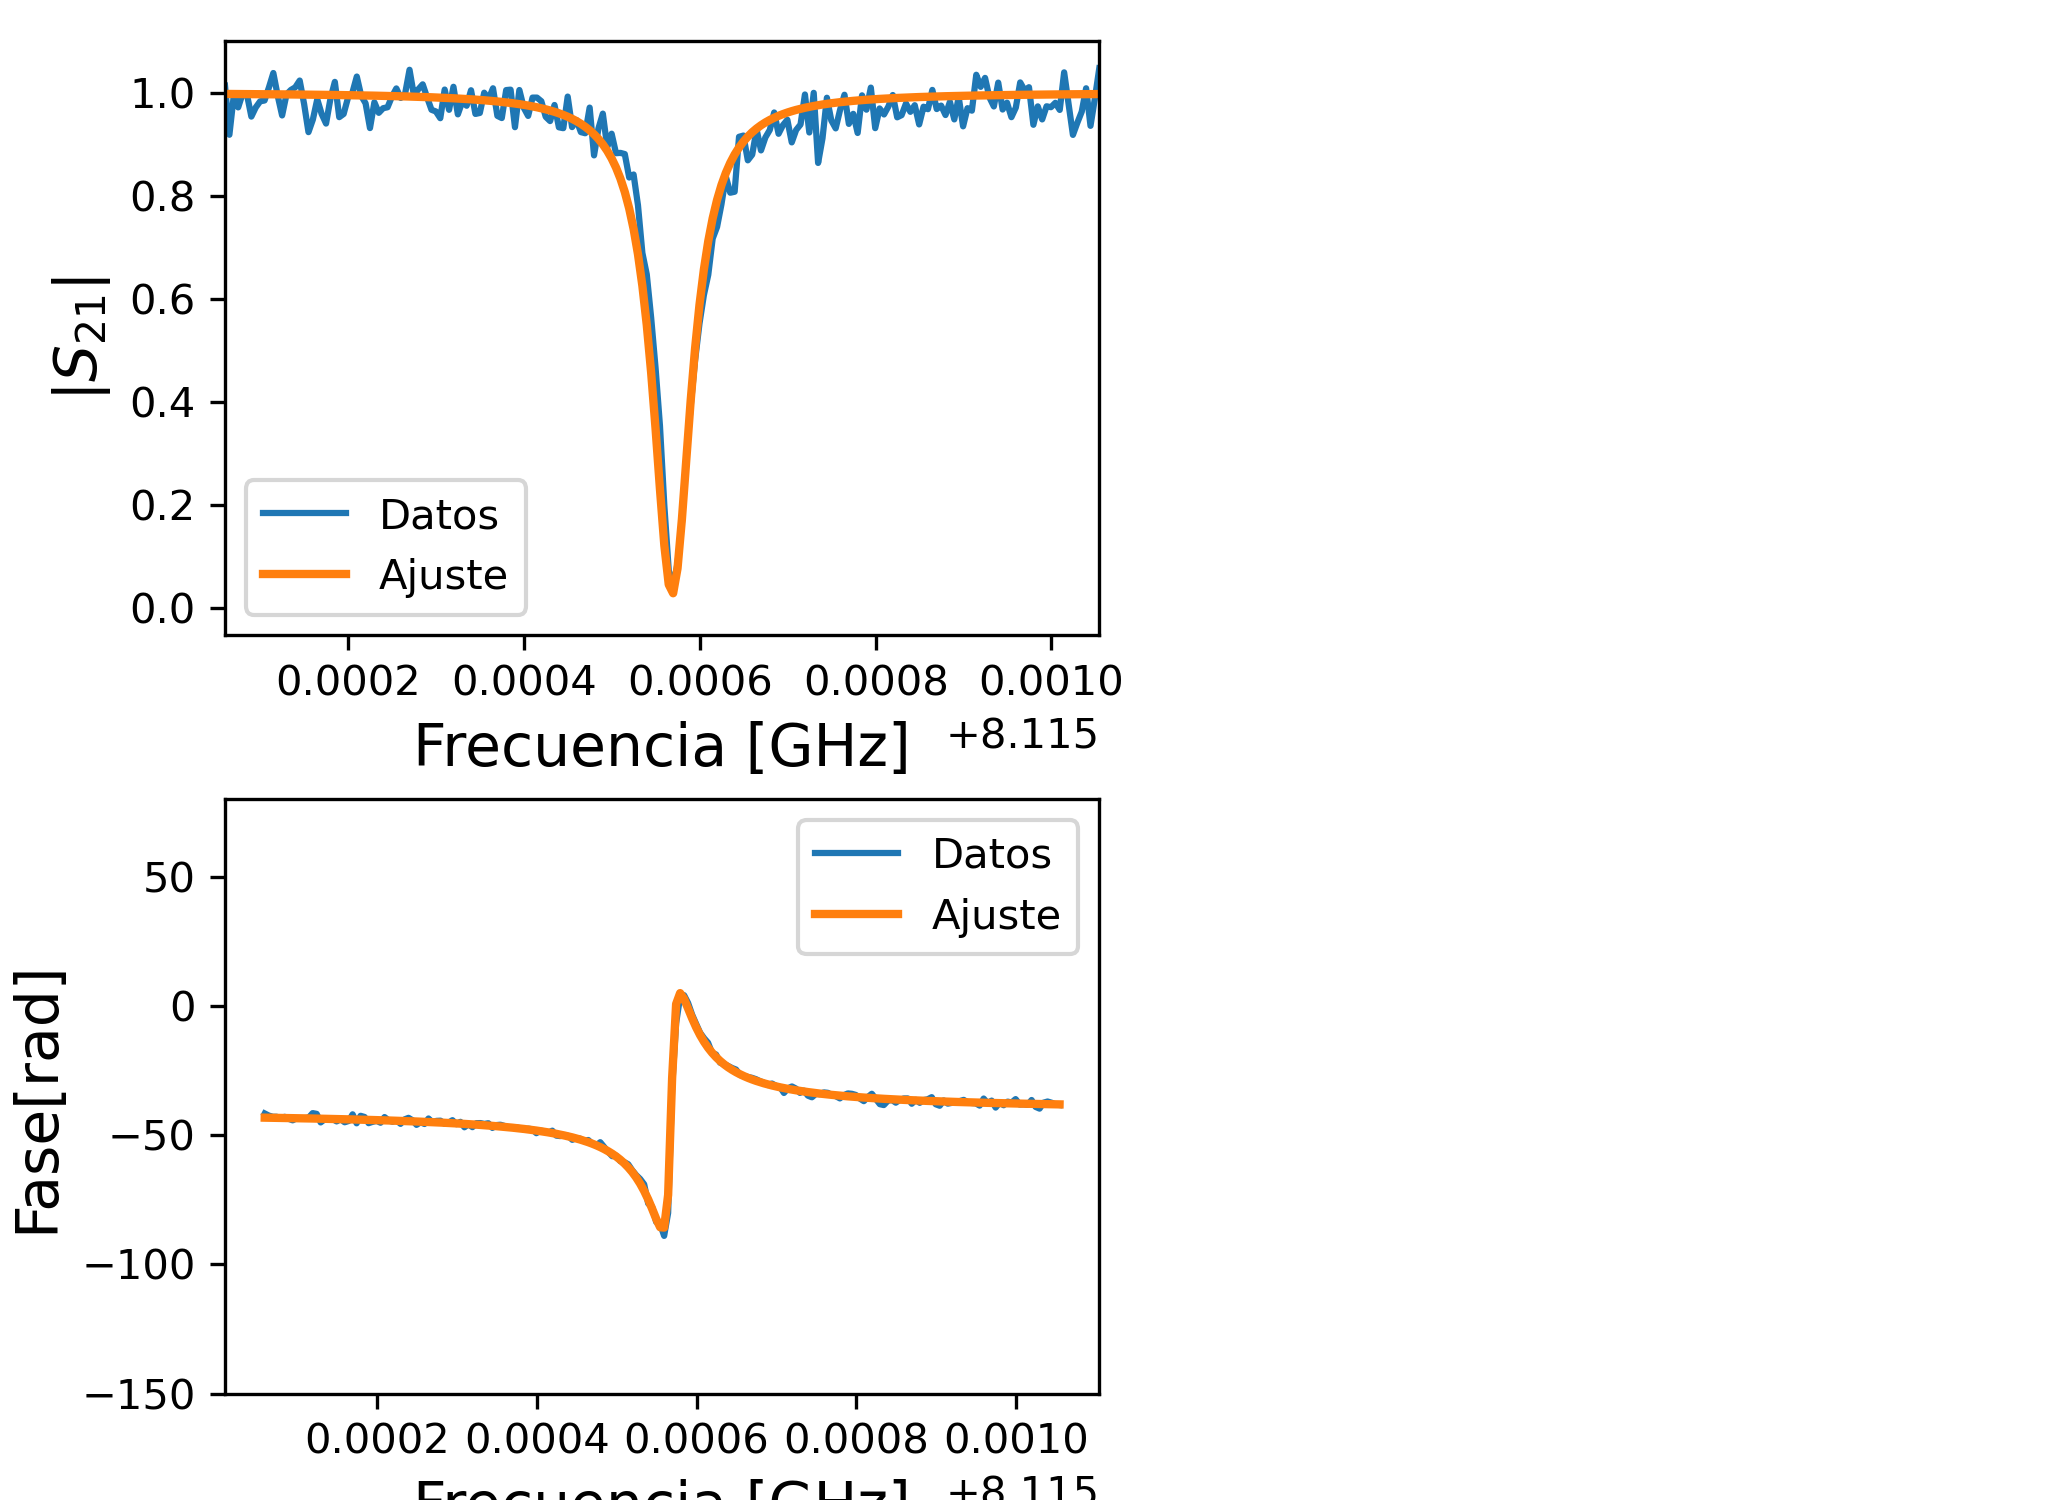

In [94]:
with Image.open("image.png") as im:
    (left, upper, right, lower) = (450, 200, 2500, 1700)
    im_crop = im.crop((left, upper, right, lower))
  #  im_crop=im_crop.convert('L')
im_crop

In [10]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Función para guardar la figura en PDF con el tamaño especificado
def save_image_as_pdf(width, height, dpi=300):
    # Crear una figura de Matplotlib con el tamaño deseado
    fig = plt.figure(figsize=(width, height))

    # Aquí puedes agregar tu código para crear el gráfico o la visualización
    # Por ejemplo, puedes usar plt.plot() para crear un gráfico de ejemplo:
    # plt.plot([1, 2, 3, 4], [1, 2, 1, 3])

    # Guardar la figura en un archivo PDF con la resolución especificada
    fig.savefig('output.pdf', dpi=dpi, format='pdf')

    # Cierra la figura después de guardarla
    plt.close(fig)

# Crear widgets para ajustar el tamaño de la figura
width_slider = widgets.FloatSlider(value=5, min=1, max=10, step=0.1, description='Width:')
height_slider = widgets.FloatSlider(value=8, min=1, max=10, step=0.1, description='Height:')
save_button = widgets.Button(description='Save as PDF')

# Función para manejar el evento de clic en el botón
def save_button_clicked(b):
    save_image_as_pdf(width_slider.value, height_slider.value)

save_button.on_click(save_button_clicked)

# Mostrar los widgets en el notebook
display(width_slider)
display(height_slider)
display(save_button)


FloatSlider(value=5.0, description='Width:', max=10.0, min=1.0)

FloatSlider(value=8.0, description='Height:', max=10.0, min=1.0)

Button(description='Save as PDF', style=ButtonStyle())

In [17]:
fig.savefig('hola.pdf')